In [9]:
# for interactive plot only, run before matplotlib import
%matplotlib ipympl

# Simulation configuration

In [10]:
import os
import dynamic_sound as ds
import matplotlib.pyplot as plt

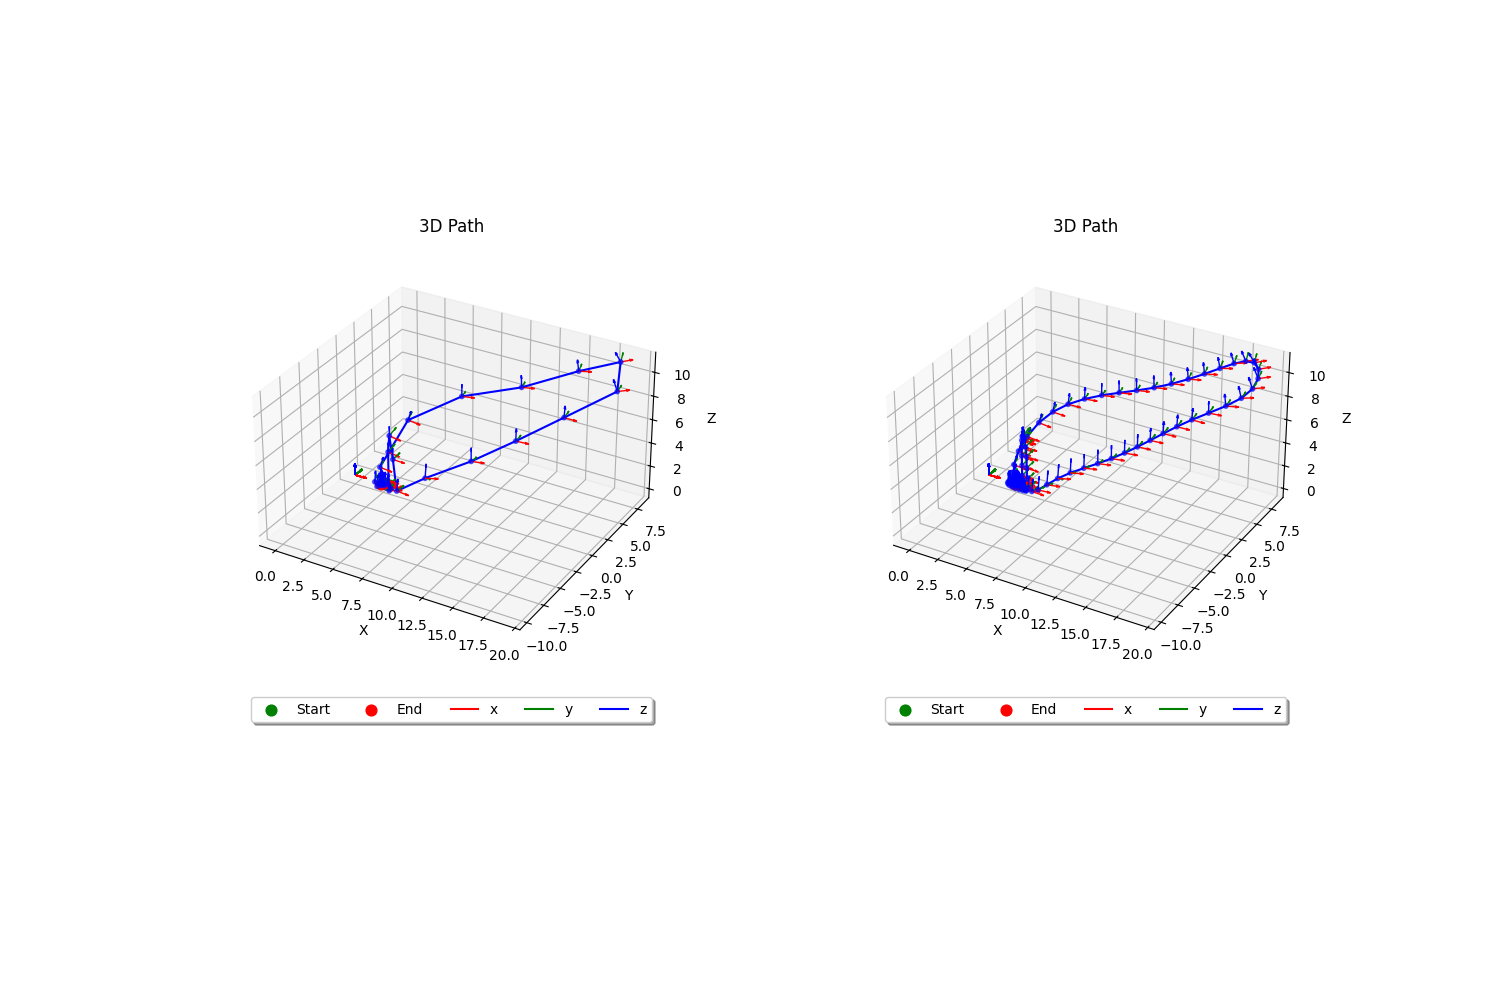

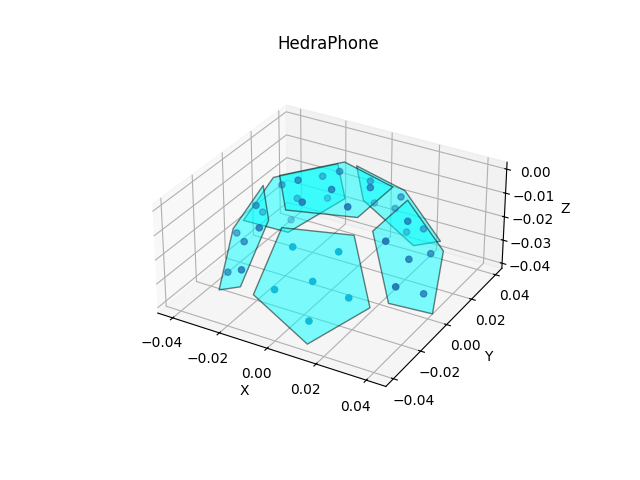

In [11]:
src_folder = r"airsim/data/run1/converted"
drone_path = ds.Path(file=os.path.join(src_folder, "drone_path.csv"))
# drone_path = ds.Path([
#     [0.0,   3, -30, 1,   1, 0, 0, 0],
#     [10.0,  3,  30, 1,   1, 0, 0, 0]
# ])
microphone_path = ds.Path(file=os.path.join(src_folder, "camera_path.csv"))
# microphone_path = ds.Path([
#     [0.0,   0, 0, 0,   1, 0, 0, 0],
#     [10.0,  0, 0, 0,   1, 0, 0, 0]
# ])
drone_sound = r"../tests/resources/sounds/flying_drone.wav"

# path interpolation
fig = plt.figure(figsize=(15, 10))
ax1 = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122, projection='3d')
drone_path.plot_path_3d(show=False, ax=ax1)
drone_path.plot_quaternion_directions(scale=1.0, show=False, ax=ax1, legend=False)
microphone_path.plot_quaternion_directions(scale=1.0, show=False, ax=ax1)
drone_path.interpolate_path(100)
drone_path.plot_path_3d(show=False, ax=ax2)
drone_path.plot_quaternion_directions(scale=1.0, show=False, ax=ax2, legend=False)
microphone_path.plot_quaternion_directions(scale=1.0, show=False, ax=ax2)
ax1.set_aspect('equal')
ax2.set_aspect('equal')
plt.show()


mic_sample_rate = 24_000

# simulation environment
sim = ds.Simulation(
    temperature=20,
    pressure=1,
    relative_humidity=50
)

# microphone
microphone = ds.microphones.Hedraphone_v2("_tmp/simulation_sound_drone.wav", sample_rate=mic_sample_rate)
sim.add_microphone(path=microphone_path, microphone=microphone)
microphone.plot_figure(show=True)

# source
source = ds.sources.AudioFile(filename=drone_sound, sample_rate=48_000, gain_db=10.0, loop=True)
#source = ds.sources.SineWave(2_000, sample_rate=48_000, amplitude=1.0)
sim.add_source(
    path=drone_path,
    source=source
)

# reflection
# drone_path.positions[:,3] = -drone_path.positions[:,3]
# sim.add_source(
#     path=drone_path,
#     source=source
# )

# Simulation run

In [12]:
sim.run()

  0%|          | 889/696000 [00:13<2:59:49, 64.43it/s] 


KeyboardInterrupt: 

# Simulation results visualization

In [13]:
import matplotlib.pyplot as plt
import librosa
import IPython.display as ipd
import numpy as np
import pyroomacoustics as pra

In [ ]:
signal, sr = librosa.load("_tmp/simulation_sound_drone.wav", sr=6000, mono=False)

if signal.ndim == 1:  # if single channel reshape to a common format (n_channels, n_samples)
    signal = signal.reshape(1, -1)
    
ipd.display(ipd.Audio(signal[0], rate=sr))

D = librosa.stft(signal[0])
S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)

plt.figure(figsize=(10, 4))
librosa.display.specshow(S_db, sr=sr, x_axis='time', y_axis='hz')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram')
plt.tight_layout()
plt.show()

ValueError: zero-size array to reduction operation maximum which has no identity

In [7]:
import pyroomacoustics as pra
import librosa
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from tqdm import tqdm

samples_out, sr = librosa.load("_tmp/simulation_sound.wav", sr=None, mono=False)
print(samples_out.shape)

c = 343.0  # speed of sound
nfft = 126 #256  # FFT size

freq_bins = range(30, 31) # sine wave freq
#freq_bins = range(6, 7)   # drone freq
freq_range = [(min(freq_bins)*sr)/nfft, (max(freq_bins)*sr)/nfft]  # FFT bins to use for estimation
print(f"freq range {freq_range}")

resolution_step = 1  # degrees
algo = pra.doa.normmusic.NormMUSIC(L=microphone.get_microphones().T, c=c, fs=sr, nfft=nfft,
                                azimuth=np.deg2rad(np.arange(-180, 180, resolution_step)),
                                colatitude=np.deg2rad(np.arange(0, 180, resolution_step)),
                                dim=3, mode='near')
num_frames = 30
window_size = int(0.25*sr)
images = []
for start_sample in tqdm( range(0, len(samples_out[0])-window_size, len(samples_out[0]-window_size)//num_frames) ):

    X = np.array(
        [pra.transform.stft.analysis(signal, nfft, nfft // 2).T for signal in samples_out[:, start_sample:start_sample+window_size]]
    )
    algo.locate_sources(X, freq_bins=freq_bins)

    spatial_resp = algo.grid.values
    min_val = spatial_resp.min()
    max_val = spatial_resp.max()
    spatial_resp = (spatial_resp - min_val) / (max_val - min_val)
    images.append(spatial_resp.reshape((-1, 360//resolution_step)))

fig, ax = plt.subplots()
img = ax.imshow(images[0], animated=True)
fig.set_size_inches(16, 4)
ax.set_aspect(1)

def update(frame):
    img.set_array(images[frame])
    return [img]

ani = FuncAnimation(fig, update, frames=len(images), interval=30000//num_frames, blit=True, repeat=True)
HTML(ani.to_jshtml())

(384000,)
freq range [11428.57142857143, 11428.57142857143]


TypeError: object of type 'numpy.float32' has no len()